In [1]:
# Import our dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Fix a random seed so the data can be reproduced
np.random.seed(24)

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv", index_col=0)

In [2]:
# Look at our data
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
2018/01/01,9,37,145,44,27,13,12,7
2018/01/02,13,45,119,41,27,14,19,10
2018/01/03,13,44,106,40,36,14,20,11
2018/01/04,15,44,103,45,30,10,15,12
2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(axis=1)
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
2018/01/01,9,37,145,44,27,13,12,7,294
2018/01/02,13,45,119,41,27,14,19,10,288
2018/01/03,13,44,106,40,36,14,20,11,284
2018/01/04,15,44,103,45,30,10,15,12,274
2018/01/05,10,45,107,41,26,13,21,10,273


In [4]:
# And then check DataFrame for type and any nans
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018/01/01 to 2018/12/31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fishing       365 non-null    int64
 1   TugTow        365 non-null    int64
 2   Recreational  365 non-null    int64
 3   Passenger     365 non-null    int64
 4   Cargo         365 non-null    int64
 5   Tanker        365 non-null    int64
 6   Other         365 non-null    int64
 7   Unavailable   365 non-null    int64
 8   Total         365 non-null    int64
dtypes: int64(9)
memory usage: 28.5+ KB


In [5]:
# Create nine DataFrames, one for each type of boat and the total:

# Fishing
ais_fishing_df = ais_df.loc[:, ['Fishing']]

# TugTow
ais_tugtow_df = ais_df.loc[:, ['TugTow']]

# Recreational
ais_recreational_df = ais_df.loc[:, ['Recreational']]

# Passenger
ais_passenger_df = ais_df.loc[:, ['Passenger']]

# Cargo
ais_cargo_df = ais_df.loc[:, ['Cargo']]

# Tanker
ais_tanker_df = ais_df.loc[:, ['Tanker']]

# Other
ais_other_df = ais_df.loc[:, ['Other']]

# Unavailable
ais_unavailable_df = ais_df.loc[:, ['Unavailable']]

# Total
ais_total_df = ais_df.loc[:, ['Total']]

In [6]:
# From here, the code is heavily inspired by the code found on the following sites:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816

In [7]:
# Creating a function to automate making a model for all nine Dataframes
def BoatModel (x):
    # Convert the DataFrame into an array, and change the type to floats for the Neural Network
    data = x.values
    data = data.astype('float32')
    
    # Normalize the data by using a scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    # Split our data into training and testing using slicing, and check the length

    # Determin the length of what our split will be
    data_split = int(len(data) * 0.75)
    
    #Slice the data and print the results
    train, test = data[:data_split], data[data_split:]
    
    # Make a function that creates both X and y values for the data
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    
    # Define how much time we're looking into the past, 
    # and split our values into X=t and Y=t+1, where t is that time
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # Reshape the data to incorperate into the LSTM
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, activation='relu', input_shape=(1, look_back)))
    model.add(Dense(2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    es = [EarlyStopping(monitor='loss', patience=15)]
    fit_model = model.fit(trainX, trainY, epochs=100, validation_split=0.3, batch_size=1, verbose=2, callbacks=[es])
    
    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # Invert the predictions to graph later
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    # Calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    
    # And catch the results to print later
    show_trainScore = 'Train Score: %.2f RMSE' % (trainScore)
    show_testScore = 'Test Score: %.2f RMSE' % (testScore)
    
    # Shift the train predictions for plotting
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    
    # Shift the test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
     
   # Create a function for future predictions
    
    def predict(num_prediction, model):
        prediction_list = data[-look_back:]
    
        for _ in range(num_prediction):
            x = prediction_list[-look_back:]
            x = x.reshape((1, look_back, 1))
            out = model.predict(x)[0][0]
            prediction_list = np.append(prediction_list, out)
        prediction_list = prediction_list[look_back-1:]
        
        return prediction_list
    
    # Predict the next 30 days of data
    forecast = predict(30, model)
    forecast = forecast.reshape((-1,1))
    forecast = scaler.inverse_transform(forecast)
    
    # Plot the prediction on a graph
    
    future = len(data) + len(forecast)

    futurePlot = np.zeros((future ,1))
    futurePlot[:, :] = np.nan
    futurePlot[-len(forecast): ] = forecast

    
     # Plot the root data, train, test, and future outcomes
    plt.plot(scaler.inverse_transform(data))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.plot(futurePlot)
    graph = plt.show()
  
    return show_trainScore, show_testScore, graph

### Fishing

Epoch 1/100
189/189 - 1s - loss: 0.0883 - mse: 0.0883 - mae: 0.2401 - mape: 54.7993 - val_loss: 0.0434 - val_mse: 0.0434 - val_mae: 0.1645 - val_mape: 30.0575 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0236 - mse: 0.0236 - mae: 0.1211 - mape: 34.8407 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1260 - val_mape: 25.6021 - 292ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0207 - mse: 0.0207 - mae: 0.1180 - mape: 36.0260 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1228 - val_mape: 25.8514 - 303ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0195 - mse: 0.0195 - mae: 0.1158 - mape: 35.2120 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1270 - val_mape: 25.9614 - 356ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0185 - mse: 0.0185 - mae: 0.1117 - mape: 33.5206 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1231 - val_mape: 26.3496 - 349ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0177 - mse: 0.0177 - mae: 0.1097 - mape: 33.2104

Epoch 46/100
189/189 - 0s - loss: 0.0145 - mse: 0.0145 - mae: 0.0956 - mape: 27.2801 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1335 - val_mape: 29.5107 - 369ms/epoch - 2ms/step
Epoch 47/100
189/189 - 0s - loss: 0.0146 - mse: 0.0146 - mae: 0.0955 - mape: 27.4307 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1315 - val_mape: 29.5908 - 458ms/epoch - 2ms/step
Epoch 48/100
189/189 - 0s - loss: 0.0143 - mse: 0.0143 - mae: 0.0950 - mape: 27.4392 - val_loss: 0.0263 - val_mse: 0.0263 - val_mae: 0.1347 - val_mape: 29.5316 - 433ms/epoch - 2ms/step
Epoch 49/100
189/189 - 0s - loss: 0.0144 - mse: 0.0144 - mae: 0.0941 - mape: 26.7343 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1343 - val_mape: 29.5218 - 351ms/epoch - 2ms/step
Epoch 50/100
189/189 - 0s - loss: 0.0144 - mse: 0.0144 - mae: 0.0950 - mape: 27.5071 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1314 - val_mape: 29.5525 - 323ms/epoch - 2ms/step
Epoch 51/100
189/189 - 0s - loss: 0.0143 - mse: 0.0143 - mae: 0.0947 - mape

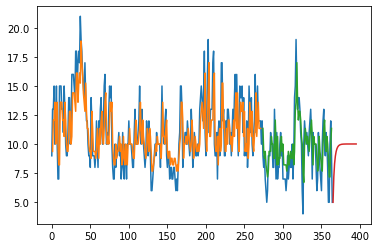

('Train Score: 2.28 RMSE', 'Test Score: 2.03 RMSE', None)

In [8]:
BoatModel(ais_fishing_df)

### TugTow

Epoch 1/100
189/189 - 1s - loss: 0.0486 - mse: 0.0486 - mae: 0.1720 - mape: 1278631.7500 - val_loss: 0.0285 - val_mse: 0.0285 - val_mae: 0.1335 - val_mape: 22.8549 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0153 - mse: 0.0153 - mae: 0.0976 - mape: 1887178.3750 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1095 - val_mape: 19.6376 - 314ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0157 - mse: 0.0157 - mae: 0.0981 - mape: 1954152.0000 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1371 - val_mape: 23.3583 - 311ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0155 - mse: 0.0155 - mae: 0.0987 - mape: 1911993.0000 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1301 - val_mape: 22.2666 - 314ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0151 - mse: 0.0151 - mae: 0.0971 - mape: 2024982.3750 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1208 - val_mape: 20.9705 - 308ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0151 - mse: 0.0151 - ma

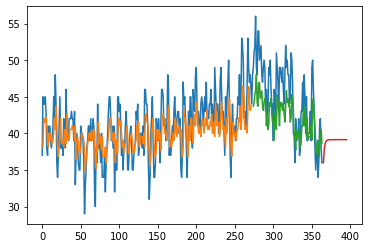

('Train Score: 3.45 RMSE', 'Test Score: 4.51 RMSE', None)

In [18]:
BoatModel(ais_tugtow_df)

### Recreational

Epoch 1/100
189/189 - 1s - loss: 0.0368 - mse: 0.0368 - mae: 0.1462 - mape: 933501.3750 - val_loss: 0.0290 - val_mse: 0.0290 - val_mae: 0.1314 - val_mape: 22.5973 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0254 - mse: 0.0254 - mae: 0.1307 - mape: 1083180.6250 - val_loss: 0.0343 - val_mse: 0.0343 - val_mae: 0.1456 - val_mape: 24.6922 - 287ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0243 - mse: 0.0243 - mae: 0.1270 - mape: 938541.4375 - val_loss: 0.0242 - val_mse: 0.0242 - val_mae: 0.1238 - val_mape: 22.1293 - 296ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0241 - mse: 0.0241 - mae: 0.1273 - mape: 940233.5000 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.1301 - val_mape: 22.9100 - 328ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0230 - mse: 0.0230 - mae: 0.1246 - mape: 770189.1250 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1276 - val_mape: 22.7357 - 302ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0231 - mse: 0.0231 - mae: 0

Epoch 45/100
189/189 - 0s - loss: 0.0222 - mse: 0.0222 - mae: 0.1179 - mape: 428322.0625 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1252 - val_mape: 22.7215 - 309ms/epoch - 2ms/step
Epoch 46/100
189/189 - 0s - loss: 0.0222 - mse: 0.0222 - mae: 0.1184 - mape: 462828.5625 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1211 - val_mape: 22.3083 - 358ms/epoch - 2ms/step
Epoch 47/100
189/189 - 0s - loss: 0.0223 - mse: 0.0223 - mae: 0.1187 - mape: 609230.7500 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1192 - val_mape: 22.1822 - 304ms/epoch - 2ms/step
Epoch 48/100
189/189 - 0s - loss: 0.0222 - mse: 0.0222 - mae: 0.1205 - mape: 549664.6250 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1306 - val_mape: 23.3030 - 294ms/epoch - 2ms/step
Epoch 49/100
189/189 - 0s - loss: 0.0223 - mse: 0.0223 - mae: 0.1184 - mape: 424604.7812 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1192 - val_mape: 22.1607 - 316ms/epoch - 2ms/step
Epoch 50/100
189/189 - 0s - loss: 0.0221 - mse: 0.0221 

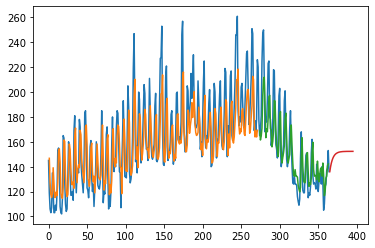

('Train Score: 23.89 RMSE', 'Test Score: 18.51 RMSE', None)

In [10]:
BoatModel(ais_recreational_df)

### Passenger

Epoch 1/100
189/189 - 1s - loss: 0.1288 - mse: 0.1288 - mae: 0.3115 - mape: 1842332.2500 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.2234 - val_mape: 34.8016 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0290 - mse: 0.0290 - mae: 0.1364 - mape: 2537209.2500 - val_loss: 0.0182 - val_mse: 0.0182 - val_mae: 0.1134 - val_mape: 17.2094 - 321ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0251 - mse: 0.0251 - mae: 0.1267 - mape: 2637990.0000 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.1214 - val_mape: 18.4241 - 326ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0244 - mse: 0.0244 - mae: 0.1241 - mape: 2569647.5000 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1291 - val_mape: 19.6399 - 345ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0239 - mse: 0.0239 - mae: 0.1233 - mape: 2445108.5000 - val_loss: 0.0131 - val_mse: 0.0131 - val_mae: 0.0944 - val_mape: 14.5148 - 327ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0231 - mse: 0.0231 - ma

1/1 [==============================] - 0s 15ms/step


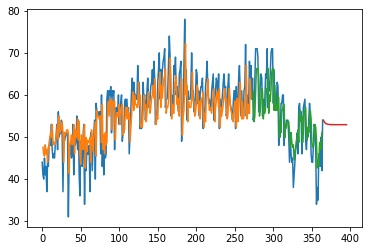

('Train Score: 5.93 RMSE', 'Test Score: 5.59 RMSE', None)

In [11]:
BoatModel(ais_passenger_df)

### Cargo

Epoch 1/100
189/189 - 2s - loss: 0.1379 - mse: 0.1379 - mae: 0.3065 - mape: 1013340.6875 - val_loss: 0.0414 - val_mse: 0.0414 - val_mae: 0.1693 - val_mape: 32.9803 - 2s/epoch - 8ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0299 - mse: 0.0299 - mae: 0.1377 - mape: 2269881.5000 - val_loss: 0.0294 - val_mse: 0.0294 - val_mae: 0.1366 - val_mape: 29.7252 - 315ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0279 - mse: 0.0279 - mae: 0.1321 - mape: 2292605.0000 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1279 - val_mape: 28.6581 - 376ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0266 - mse: 0.0266 - mae: 0.1311 - mape: 2108192.0000 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1276 - val_mape: 28.0043 - 361ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0255 - mse: 0.0255 - mae: 0.1286 - mape: 2171674.0000 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1294 - val_mape: 27.6061 - 318ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0247 - mse: 0.0247 - ma

1/1 [==============================] - 0s 17ms/step


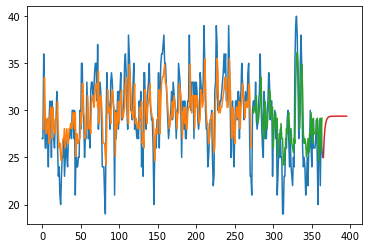

('Train Score: 3.11 RMSE', 'Test Score: 3.40 RMSE', None)

In [12]:
BoatModel(ais_cargo_df)

### Tanker

Epoch 1/100
189/189 - 1s - loss: 0.1009 - mse: 0.1009 - mae: 0.2647 - mape: 48.2385 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1196 - val_mape: 69.1428 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0186 - mse: 0.0186 - mae: 0.1094 - mape: 23.8311 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.1376 - val_mape: 79.1778 - 305ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0177 - mse: 0.0177 - mae: 0.1078 - mape: 23.9601 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1295 - val_mape: 74.5235 - 313ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0167 - mse: 0.0167 - mae: 0.1049 - mape: 23.4921 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1196 - val_mape: 68.7513 - 306ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0159 - mse: 0.0159 - mae: 0.1022 - mape: 22.6927 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1168 - val_mape: 66.6571 - 323ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0150 - mse: 0.0150 - mae: 0.0989 - mape: 21.6082

1/1 [==============================] - 0s 17ms/step


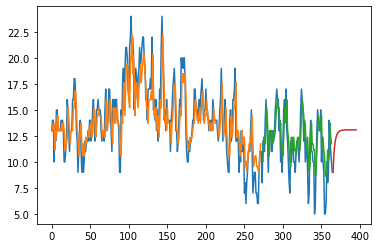

('Train Score: 2.06 RMSE', 'Test Score: 2.19 RMSE', None)

In [13]:
BoatModel(ais_tanker_df)

### Other

Epoch 1/100
189/189 - 1s - loss: 0.0217 - mse: 0.0217 - mae: 0.1168 - mape: 2512509.0000 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.1011 - val_mape: 40.5569 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0816 - mape: 2647470.5000 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0987 - val_mape: 40.4251 - 304ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0819 - mape: 2627656.7500 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.0982 - val_mape: 39.9432 - 324ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0790 - mape: 2495491.5000 - val_loss: 0.0139 - val_mse: 0.0139 - val_mae: 0.0934 - val_mape: 41.1402 - 318ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0800 - mape: 2671743.7500 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0965 - val_mape: 38.7582 - 316ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0096 - mse: 0.0096 - ma

1/1 [==============================] - 0s 17ms/step


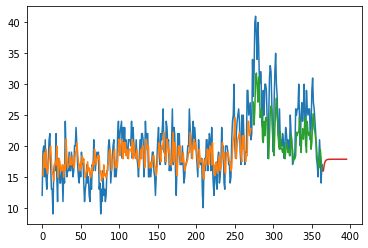

('Train Score: 3.15 RMSE', 'Test Score: 4.95 RMSE', None)

In [19]:
BoatModel(ais_other_df)

### Unavailable 

Epoch 1/100
189/189 - 2s - loss: 0.0181 - mse: 0.0181 - mae: 0.1040 - mape: 1813459.2500 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1778 - val_mape: 48.9439 - 2s/epoch - 8ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0099 - mse: 0.0099 - mae: 0.0799 - mape: 3006571.7500 - val_loss: 0.0592 - val_mse: 0.0592 - val_mae: 0.1737 - val_mape: 48.7691 - 301ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0098 - mse: 0.0098 - mae: 0.0796 - mape: 2973197.2500 - val_loss: 0.0574 - val_mse: 0.0574 - val_mae: 0.1712 - val_mape: 48.1229 - 310ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0096 - mse: 0.0096 - mae: 0.0796 - mape: 2935393.5000 - val_loss: 0.0577 - val_mse: 0.0577 - val_mae: 0.1712 - val_mape: 46.6382 - 308ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0094 - mse: 0.0094 - mae: 0.0781 - mape: 2842178.7500 - val_loss: 0.0534 - val_mse: 0.0534 - val_mae: 0.1655 - val_mape: 46.4141 - 313ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0094 - mse: 0.0094 - ma

Epoch 45/100
189/189 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0708 - mape: 2438944.2500 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1103 - val_mape: 36.4456 - 308ms/epoch - 2ms/step
Epoch 46/100
189/189 - 0s - loss: 0.0080 - mse: 0.0080 - mae: 0.0708 - mape: 2430364.0000 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1132 - val_mape: 36.1041 - 299ms/epoch - 2ms/step
Epoch 47/100
189/189 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0706 - mape: 2447151.5000 - val_loss: 0.0233 - val_mse: 0.0233 - val_mae: 0.1145 - val_mape: 36.1234 - 322ms/epoch - 2ms/step
Epoch 48/100
189/189 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0707 - mape: 2290499.5000 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1148 - val_mape: 36.1303 - 303ms/epoch - 2ms/step
Epoch 49/100
189/189 - 0s - loss: 0.0079 - mse: 0.0079 - mae: 0.0705 - mape: 2455445.7500 - val_loss: 0.0232 - val_mse: 0.0232 - val_mae: 0.1143 - val_mape: 36.1029 - 302ms/epoch - 2ms/step
Epoch 50/100
189/189 - 0s - loss: 0.0079 - mse: 0.

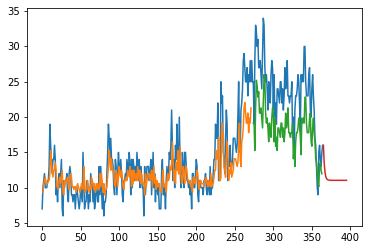

('Train Score: 3.08 RMSE', 'Test Score: 6.02 RMSE', None)

In [20]:
BoatModel(ais_unavailable_df)

### Total

Epoch 1/100
189/189 - 1s - loss: 0.0508 - mse: 0.0508 - mae: 0.1815 - mape: 57.9245 - val_loss: 0.0437 - val_mse: 0.0437 - val_mae: 0.1833 - val_mape: 30.0803 - 1s/epoch - 7ms/step
Epoch 2/100
189/189 - 0s - loss: 0.0205 - mse: 0.0205 - mae: 0.1159 - mape: 54.0705 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1520 - val_mape: 24.7151 - 305ms/epoch - 2ms/step
Epoch 3/100
189/189 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.1128 - mape: 54.6083 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1566 - val_mape: 25.5850 - 313ms/epoch - 2ms/step
Epoch 4/100
189/189 - 0s - loss: 0.0176 - mse: 0.0176 - mae: 0.1069 - mape: 50.7057 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1317 - val_mape: 21.4497 - 308ms/epoch - 2ms/step
Epoch 5/100
189/189 - 0s - loss: 0.0161 - mse: 0.0161 - mae: 0.1020 - mape: 49.4871 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1240 - val_mape: 20.2562 - 320ms/epoch - 2ms/step
Epoch 6/100
189/189 - 0s - loss: 0.0144 - mse: 0.0144 - mae: 0.0957 - mape: 47.3789

Epoch 46/100
189/189 - 0s - loss: 0.0102 - mse: 0.0102 - mae: 0.0807 - mape: 35.3854 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0929 - val_mape: 15.9859 - 312ms/epoch - 2ms/step
Epoch 47/100
189/189 - 0s - loss: 0.0103 - mse: 0.0103 - mae: 0.0804 - mape: 35.0217 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0875 - val_mape: 15.0842 - 299ms/epoch - 2ms/step
Epoch 48/100
189/189 - 0s - loss: 0.0101 - mse: 0.0101 - mae: 0.0798 - mape: 34.6852 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0678 - val_mape: 12.0568 - 293ms/epoch - 2ms/step
Epoch 49/100
189/189 - 0s - loss: 0.0101 - mse: 0.0101 - mae: 0.0796 - mape: 35.5725 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0748 - val_mape: 13.0620 - 305ms/epoch - 2ms/step
Epoch 50/100
189/189 - 0s - loss: 0.0097 - mse: 0.0097 - mae: 0.0781 - mape: 34.0932 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0949 - val_mape: 16.3166 - 298ms/epoch - 2ms/step
Epoch 51/100
189/189 - 0s - loss: 0.0101 - mse: 0.0101 - mae: 0.0799 - mape

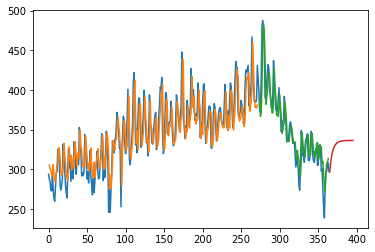

('Train Score: 23.91 RMSE', 'Test Score: 19.71 RMSE', None)

In [17]:
BoatModel(ais_total_df)